<a href="https://colab.research.google.com/github/Nagmashaik123/Section203-Group06/blob/main/model_LDA_on_Vaccine_Brands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import re
import os
import io
import spacy
import string
import numpy as np
import pandas as pd

# Gensim
import gensim
from gensim import models
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import warnings
warnings.filterwarnings('ignore')


# Read and Prepare Dataset

In [2]:
dataset = pd.read_csv("ProcessedCovidVaccineReact.csv", index_col=0)
dataset.shape

(206250, 6)

In [3]:
dataset = dataset.dropna() # drop null values
dataset.shape

(205574, 6)

In [4]:
dataset.head(5)

,TweetText,CleanedTweet,TweetAuthor,TweetLocation,AllHashtags,Country
TweetDate,,,,,,
2021-04-02 23:59:56,RT @ichaydon: A year ago I tried the Moderna v...,rt ichaydon year ago tried moderna vaccine see...,realbafomet,United Arab Emirates,['COVIDvaccine'],United Arab Emirates
2021-04-02 23:59:53,RT @hotvickkrishna: Why we need Two Doses of m...,rt hotvickkrishna need two doses mrna vaccine ...,EVANtiel,Unknown,"['vaccines', 'COVID19', 'Pfizer', 'moderna', '...",Unknown
2021-04-02 23:59:46,RT @StephMillerShow: Stick it in! Moderna Mama...,rt stephmillershow stick moderna mama house ya...,anessia40,Unknown,"['vaccinated', 'VaccinesWork', 'VaccinesSaveLi...",Unknown
2021-04-02 23:59:43,RT @hotvickkrishna: Why we need Two Doses of m...,rt hotvickkrishna need two doses mrna vaccine ...,tammeeh,Kota Petir,"['vaccines', 'COVID19', 'Pfizer', 'moderna', '...",Indonesia
2021-04-02 23:59:43,RT @ichaydon: A year ago I tried the Moderna v...,rt ichaydon year ago tried moderna vaccine see...,shipshape555,San Diego,['COVIDvaccine'],United States


In [5]:
text_data = dataset["CleanedTweet"]  # select cleaned tweets column

In [6]:
text__data =  [text.split() for text in text_data]  # tokenize dataset

In [7]:
len(text__data)

205574

In [9]:

pfizer_Vaccine = [ 'pfizer', 'pfizervaccine','pfizercovidvaccine','modernapfizer','biotech','pfizerbiotech','pfizerbiontech'] 
Moderna_Vaccine =['modernavaccine','teammoderna','moderna','modernagang','modernas'] # Moderna Vaccine
Johnson_Vaccine = ['johnsonandjohnson','johnsonandjohnsonvaccine','johnsonjohnson','johnsons','borisjohnsons','johnsonampjohnson','johnsonjohnsonvax','johnsonand'] # johnsonandjohnson Vaccine
Covaxin_Vaccine =['covax','vax','covaxin','covaxsd','covaxinrockstheworld','covaxvaccinations','covaxinreiterated'] # Covaxin Vaccine
Covishield_Vaccine =['covishield','covishieldvaccine','covishielded'] # Covishield Vaccine
Astrazeneca_Vaccine = ['astrazeneca','breakingastrazeneca','oxfordastrazeneca','astrazenecas',
                       'astrazenecavaccine','astrazenecaoxford','astrazenecauk']
Janssen_Vaccine = ['janssenglobal','janssenvaccine','janssen','janssenus']
Sputnik_Vaccine = ['sputnikint','sputnik','sputnikvaccine','sputnikv','sputnikvaccineke',
                   'sputnikvaccineinkenya','sputnikvaccinekenya']         


text_data = []
for tweetSentence in text__data:
  
  sent = []
  for tweetWord in tweetSentence:
    if tweetWord in pfizer_Vaccine:
      sent.append('Pfizer')
    elif tweetWord in Moderna_Vaccine:
      sent.append('Moderna')
    elif tweetWord in Astrazeneca_Vaccine:
      sent.append('Astrazenca')
    elif tweetWord in Johnson_Vaccine:
      sent.append('Johnson&jonson')
    elif tweetWord in Covaxin_Vaccine:
      sent.append('Covaxin')
    elif tweetWord in Janssen_Vaccine:
      sent.append('Janssen')
    elif tweetWord in Sputnik_Vaccine:
      sent.append('Sputnik')
    else :
      pass
         
       
  if sent:
    text_data.append(sent)


In [10]:
text_data

[['Moderna'],
 ['Pfizer', 'Moderna'],
 ['Moderna'],
 ['Pfizer', 'Moderna'],
 ['Moderna'],
 ['Pfizer', 'Moderna'],
 ['Pfizer', 'Moderna'],
 ['Pfizer', 'Moderna'],
 ['Pfizer', 'Moderna'],
 ['Moderna'],
 ['Pfizer', 'Moderna'],
 ['Pfizer', 'Moderna'],
 ['Moderna'],
 ['Moderna', 'Pfizer'],
 ['Pfizer', 'Moderna'],
 ['Moderna'],
 ['Moderna'],
 ['Pfizer', 'Astrazenca'],
 ['Pfizer', 'Moderna'],
 ['Johnson&jonson'],
 ['Pfizer', 'Moderna'],
 ['Pfizer', 'Pfizer', 'Pfizer'],
 ['Pfizer', 'Moderna'],
 ['Pfizer', 'Moderna'],
 ['Pfizer', 'Moderna'],
 ['Pfizer', 'Moderna'],
 ['Pfizer', 'Moderna'],
 ['Moderna'],
 ['Moderna'],
 ['Pfizer', 'Moderna'],
 ['Pfizer', 'Moderna'],
 ['Covaxin'],
 ['Pfizer', 'Moderna'],
 ['Pfizer', 'Moderna'],
 ['Pfizer', 'Moderna'],
 ['Pfizer', 'Pfizer', 'Moderna'],
 ['Moderna'],
 ['Moderna'],
 ['Moderna'],
 ['Moderna'],
 ['Covaxin'],
 ['Pfizer', 'Moderna'],
 ['Pfizer', 'Moderna'],
 ['Covaxin'],
 ['Pfizer', 'Moderna'],
 ['Pfizer', 'Moderna'],
 ['Moderna'],
 ['Moderna'],
 ['Pfizer

### Make Bigrams for LDA Model

In [11]:
# Build the bigram models
bigram = gensim.models.Phrases(text_data, min_count=1) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

text_data = [bigram_mod[doc] for doc in text_data]

In [12]:
text_data[:10]

[['Moderna'],
 ['Pfizer', 'Moderna'],
 ['Moderna'],
 ['Pfizer', 'Moderna'],
 ['Moderna'],
 ['Pfizer', 'Moderna'],
 ['Pfizer', 'Moderna'],
 ['Pfizer', 'Moderna'],
 ['Pfizer', 'Moderna'],
 ['Moderna']]

# Build Dictionary

In [13]:
# make dictionary of complete corpus
dictionary_LDA = corpora.Dictionary(text_data)
# filter tokens below frequency of 3 words
dictionary_LDA.filter_extremes(no_below=3)
# index to words 
corpus = [dictionary_LDA.doc2bow(tok) for tok in text_data]

# Build LDA Model
# Compute Coherence and Preplexity
# Choose optimal number of topics

In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    
    topics_list = [2, 4, 6, 8, 10, 12]
    coherence_values = []
    perplexity_val = []
    model_list = []
    for num_topics in topics_list:
        model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary_LDA, passes=40,iterations =100, alpha=0.05, eta=0.01)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=text_data, dictionary=dictionary_LDA, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_val.append(model.log_perplexity(corpus))

    return model_list, coherence_values, perplexity_val

# Train LDA Model

In [16]:
# Can take a long time to run.
model_list, coherence_values, perplexity_val = compute_coherence_values(dictionary=dictionary_LDA, corpus=corpus, texts=text_data, start=2, limit=40, step=6)

# Plot Coherence Scores

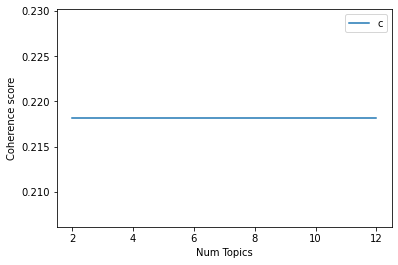

In [17]:
# Show graph
import matplotlib.pyplot as plt

topics_list = [2, 4,6, 8, 10, 12]
plt.plot(topics_list, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Plot Perplexity Scores

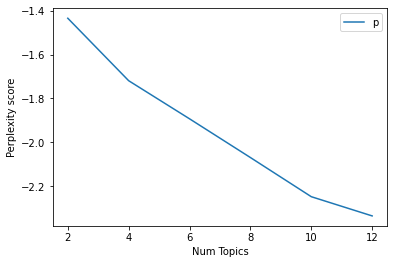

In [18]:
# Show graph
import matplotlib.pyplot as plt

topics_list = [2, 4,6, 8, 10, 12]
plt.plot(topics_list, perplexity_val)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

### Display Results

In [19]:
# Print the coherence scores
topics_list = [6, 8, 10, 12]
for m, cv, pr in zip(topics_list, coherence_values, perplexity_val):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4), " has Perplexity of", round(pr, 4))

Num Topics = 6  has Coherence Value of 0.2181  has Perplexity of -1.4345
Num Topics = 8  has Coherence Value of 0.2181  has Perplexity of -1.7194
Num Topics = 10  has Coherence Value of 0.2181  has Perplexity of -1.8931
Num Topics = 12  has Coherence Value of 0.2181  has Perplexity of -2.0697


## Train Model with Best number of topics

In [20]:
best_topic_number = 10
best_model = models.LdaModel(corpus, num_topics=best_topic_number, id2word=dictionary_LDA, passes=40, iterations = 100, alpha=0.05, eta=0.01)
        

In [21]:
coherencemodel = CoherenceModel(model=best_model, texts=text_data, dictionary=dictionary_LDA, coherence='c_v')
coherence_score = coherencemodel.get_coherence()
perplexity_score = best_model.log_perplexity(corpus)
print("Num Topics =", best_topic_number, " has Coherence Value of", round(coherence_score, 4), " has Perplexity of", round(perplexity_score, 4))
        

Num Topics = 10  has Coherence Value of 0.2181  has Perplexity of -2.1828


In [22]:
# display all topics with weight of all keywords
for i,topic in best_model.show_topics(formatted=True, num_topics=best_topic_number, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.534*"Pfizer" + 0.466*"Moderna" + 0.000*"Astrazenca" + 0.000*"Johnson&jonson" + 0.000*"Covaxin" + 0.000*"Sputnik" + 0.000*"Janssen"

1: 1.000*"Pfizer" + 0.000*"Moderna" + 0.000*"Astrazenca" + 0.000*"Johnson&jonson" + 0.000*"Covaxin" + 0.000*"Sputnik" + 0.000*"Janssen"

2: 1.000*"Astrazenca" + 0.000*"Moderna" + 0.000*"Pfizer" + 0.000*"Johnson&jonson" + 0.000*"Covaxin" + 0.000*"Sputnik" + 0.000*"Janssen"

3: 0.820*"Johnson&jonson" + 0.180*"Janssen" + 0.000*"Moderna" + 0.000*"Pfizer" + 0.000*"Astrazenca" + 0.000*"Covaxin" + 0.000*"Sputnik"

4: 1.000*"Sputnik" + 0.000*"Moderna" + 0.000*"Pfizer" + 0.000*"Astrazenca" + 0.000*"Johnson&jonson" + 0.000*"Covaxin" + 0.000*"Janssen"

5: 1.000*"Covaxin" + 0.000*"Moderna" + 0.000*"Pfizer" + 0.000*"Astrazenca" + 0.000*"Johnson&jonson" + 0.000*"Sputnik" + 0.000*"Janssen"

6: 1.000*"Moderna" + 0.000*"Pfizer" + 0.000*"Astrazenca" + 0.000*"Johnson&jonson" + 0.000*"Covaxin" + 0.000*"Sputnik" + 0.000*"Janssen"

7: 0.525*"Pfizer" + 0.475*"Moderna" + 0.0

In [27]:
!pip install pyLDAvis==3.2.2

     |████████████████████████████████| 1.7MB 4.3MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=38cd2f970d87056fdffe4c55c6e2a086b8fd3e0979a2d1ef95ebeddc9dea6d23
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis
  Found existing installation: pyLDAvis 3.3.1
    Uninstalling pyLDAvis-3.3.1:
      Successfully uninstalled pyLDAvis-3.3.1


# Visulaize Topics

In [28]:
import pyLDAvis.gensim
warnings.filterwarnings('ignore')

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, corpus, dictionary=dictionary_LDA, mds='mmds')
vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.503934  0.171505       1        1  21.809606
6      0.311851 -0.007718       2        1  16.765750
1      0.013929  0.310753       3        1  16.190923
0      0.160058  0.169415       4        1   7.348929
8      0.160706  0.168726       5        1   7.222015
7      0.161063  0.168343       6        1   7.047171
9      0.159352  0.170165       7        1   7.036441
5      0.190037 -0.496661       8        1   6.683992
3     -0.448630 -0.195876       9        1   5.686701
4     -0.204432 -0.458652      10        1   4.208472, topic_info=              Term          Freq         Total Category  logprob  loglift
2       Astrazenca   9042.000000   9042.000000  Default   7.0000   7.0000
1           Pfizer  13029.000000  13029.000000  Default   6.0000   6.0000
0          Moderna  12514.000000  12514.000000  Default   5.0000   5.0000
4          Covaxin   2771.000000   2771.000000  Default   4.0000   4.0000
3   Johnson&jonson   1932.000000   1932.000000  Default   3.0000   3.0000
..             ...           ...           ...      ...      ...      ...
3   Johnson&jonson      0.023241   1932.865442  Topic10 -11.2262  -8.1605
4          Covaxin      0.023241   2771.186614  Topic10 -11.2262  -8.5208
2       Astrazenca      0.023241   9042.133641  Topic10 -11.2262  -9.7034
0          Moderna      0.023241  12514.052181  Topic10 -11.2262 -10.0284
1           Pfizer      0.023241  13029.018456  Topic10 -11.2262 -10.0687

[77 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
2         1  0.999985      Astrazenca
4         8  0.999933         Covaxin
6         9  1.000050         Janssen
3         9  1.000070  Johnson&jonson
0         2  0.555456         Moderna
0         4  0.113472         Moderna
0         5  0.112993         Moderna
0         6  0.110995         Moderna
0         7  0.107080         Moderna
1         3  0.515235          Pfizer
1         4  0.124875          Pfizer
1         5  0.121345          Pfizer
1         6  0.117584          Pfizer
1         7  0.121038          Pfizer
5        10  1.000132         Sputnik, R=7, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 2, 1, 9, 8, 10, 6, 4, 5])

# All Topics Probabilities in each Document

In [29]:
# convert all probability distribution into dataframe (we are doing this to also keep topics having 0 probability)
# In other case topics having 0 probability will be misleading
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res


In [31]:
# find topic probabilities that model assign to all documents
topics = [best_model[corpus[i]] for i in range(len(text_data))]

In [32]:
# make dataframe of all document probability distribution
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=best_topic_number) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [33]:
document_topic.head(10)

,0,1,2,3,4,5,6,7,8,9
0,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.70,0.033333,0.033333,0.033333
1,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.02,0.020000,0.820000,0.020000
2,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.70,0.033333,0.033333,0.033333
3,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.02,0.820000,0.020000,0.020000
4,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.70,0.033333,0.033333,0.033333
5,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.02,0.020000,0.020000,0.820000
6,0.820000,0.020000,0.020000,0.020000,0.020000,0.020000,0.02,0.020000,0.020000,0.020000
7,0.020000,0.420000,0.020000,0.020000,0.020000,0.020000,0.42,0.020000,0.020000,0.020000
8,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.02,0.020000,0.820000,0.020000
9,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.70,0.033333,0.033333,0.033333


# Calculate and Find Keywords in each Document


In [34]:
def format_topics_sentences(ldamodel=best_model, corpus=corpus, texts=text_data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Per_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=best_model, corpus=corpus, texts=text_data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.70,"Moderna, Pfizer, Astrazenca, Johnson&jonson, C...",[Moderna]
1,1,7.0,0.82,"Pfizer, Moderna, Astrazenca, Johnson&jonson, C...","[Pfizer, Moderna]"
2,2,6.0,0.70,"Moderna, Pfizer, Astrazenca, Johnson&jonson, C...",[Moderna]
3,3,9.0,0.82,"Pfizer, Moderna, Astrazenca, Johnson&jonson, C...","[Pfizer, Moderna]"
4,4,6.0,0.70,"Moderna, Pfizer, Astrazenca, Johnson&jonson, C...",[Moderna]
5,5,1.0,0.42,"Pfizer, Moderna, Astrazenca, Johnson&jonson, C...","[Pfizer, Moderna]"
6,6,7.0,0.82,"Pfizer, Moderna, Astrazenca, Johnson&jonson, C...","[Pfizer, Moderna]"
7,7,8.0,0.82,"Pfizer, Moderna, Astrazenca, Johnson&jonson, C...","[Pfizer, Moderna]"
8,8,7.0,0.82,"Pfizer, Moderna, Astrazenca, Johnson&jonson, C...","[Pfizer, Moderna]"
9,9,6.0,0.70,"Moderna, Pfizer, Astrazenca, Johnson&jonson, C...",[Moderna]
